In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import os 
import sys
import numpy as np
import cv2
from dataset import SamDataset
import torch
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [9]:
dataroot = '/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD' #Change this to match the computer you are working from!
data_path=Path(dataroot, 'annotations.json')
if not data_path.is_file():
    raise(FileNotFoundError(f"File '{data_path}' doesn't exist."))

In [16]:
str(data_path)

'/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD/annotations.json'

In [41]:
train_dataset = SamDataset(dataroot=dataroot, classifier='pt', split='train')
val_dataset = SamDataset(dataroot=dataroot, classifier='pt', split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [36]:
train_dataset[1]

(('/work/amirkl/DL4CV/end-to-end-chess-recognition/chessReD/images/19/G019_IMG000.jpg',
  [1995.51, 1994.8, 156.95, 245.87]),
 'knight')

Let's try to get the segments from the dataloader output

In [40]:
from segment_anything import sam_model_registry, SamPredictor # import relevant parts of the SAM model

device = 'cuda' if torch.cuda.is_available() else 'cpu' # set the device according to availability

sam_checkpoint = os.path.join('/work/amirkl/DL4CV/segment-anything', 'sam_vit_h_4b8939.pth') #Check that the checkpoint path suits the computer you are on
model_type = 'vit_h'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) # create SAM model
sam.to(device) # move SAM to device

predictor = SamPredictor(sam) # create SAM predictor

Utility functions for plotting SAM output

In [59]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

bbox_transform = lambda x: torch.tensor([x[0],x[1],x[0]+x[2],x[1]+x[3]]) # utility function for transforming box coordinates in (x,y,w,h) to (x1,y1,x2,y2)

In [81]:
for point, label in val_loader:
    image_path = point[0]

    # print(f'{image_path[0]=}')
    image = cv2.imread(image_path[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bbox = bbox_transform(point[1]).to(predictor.device)
    print(f'{bbox=}')

    input_box = predictor.transform.apply_boxes_torch(bbox, image.shape[:2])
    predictor.set_image(image)
    masks, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=input_box,
        multimask_output=False,
    )
    print(label[0])
    break

bbox=tensor([2287.3500, 1027.9000, 2457.6600, 1362.0100], device='cuda:0',
       dtype=torch.float64)
king


Show segmentation result

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

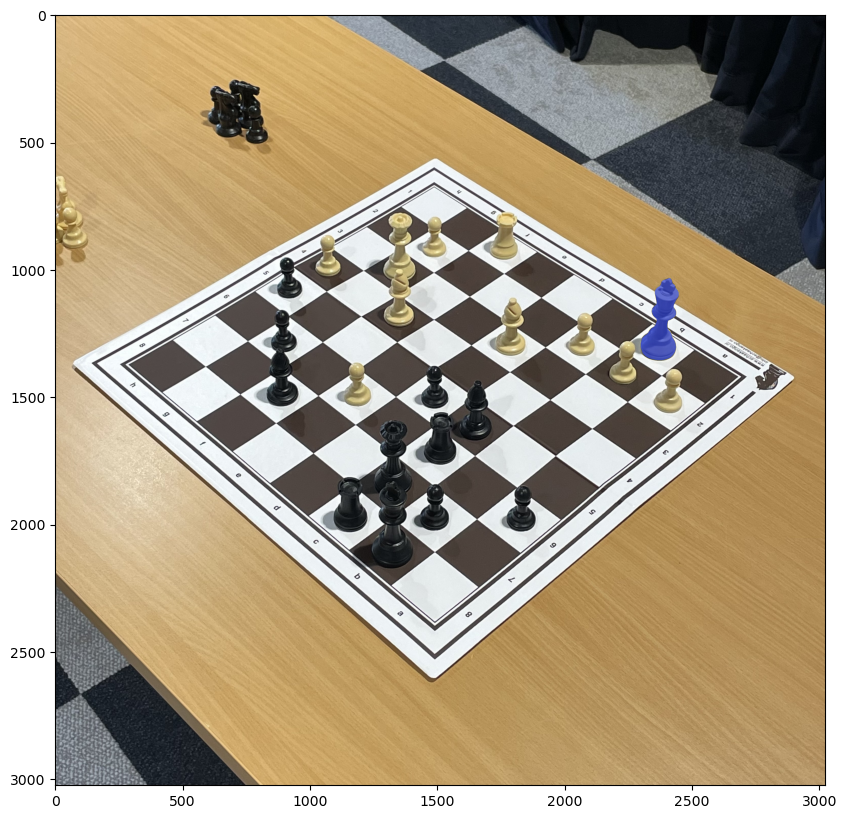

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in bbox:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('on')
plt.show()